# Programa de bicicletas compartidas (Bicycle share scheme)


Sistema práctico y al alcance de todos, en donde el usuario puede alquilar fácilmente una bicicleta y/o una bicicleta eléctrica desde cierta posición en particular, los cuales son estacionamientos específicos según la entidad que entrega el servicio, y con la opción de devolverla en otro punto de estacionamiento.

Este sistema toma un papel fundamental en la detección de eventualidades y análisis del comportamiento dentro de una ciudad. Esto debido a que, a diferencia de transportes como buses, metro o automóviles, gracias a los sensores incorporados se puede registrar la información exacta del viaje, como por ejemplo la duración, punto de inicio y punto de llegada.


## Descripción del prolema
Poniéndonos en la situación de que somos parte del equipo de la empresa Rent-Cycle en Wachington DC, y nuestro Team Leader nos da la tarea de implementar un modelo que nos permita **predecir la cantidad de bicicletas que se alquilan** según la información contenida en el dataset puesto a disposición.

**Tipo de problema**: Regresión, ya que la variable objetivo a predecir es un valor numérico

## Procedimiento
1. [Librerías](#id1)
2. [Importación de archivos](#id2)
3. [EDA: Análisis exploratorio de datos](#id3)
    <br>3.1. [Búsqueda de valores faltantes](#id3.1)
    <br>3.2. [Correlación de variables](#id3.2)
    <br>3.3. [Distribuciones](#id3.3)
4. [Feature engineering](#id4)
5. [Pre-procesamiento](#id5)
6. [Modelos de entrenamiento](#id6)
    <br>6.1. [Random Forest](#id6.1)
    <br>6.2. [XGBoost](#id6.2)
    <br>6.3. [Red Neuronal](#id6.3)
7. [Pruebas](#id7)
    <br>7.1. [Random Forest](#id7.1)
    <br>7.2. [XGBoost](#id7.2)
    <br>7.3. [Red Neuronal](#id7.3)



## 1. Librerías
<div id='id1'/>


In [1]:
import math
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 2. Importación de archivos
<div id='id2'/>

In [2]:
train_df = pd.read_excel('Dataset/bike_train.xlsx')
test_df = pd.read_excel('Dataset/bike_test_act.xlsx')

In [3]:
train_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
test_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


## 3. EDA: Análisis exploratorio de datos
<div id='id3'/>

### Búsqueda de valores faltantes
<div id='id3.1'/>

> No presentan valores faltantes ambos datasets

In [5]:
train_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
test_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

### Correlación de variables
<div id='id3.2'/>

Eliminamos la variable `instant` y `dteday`

In [7]:
train_df.drop(labels = ['instant', 'dteday'], axis = 1, inplace = True)

In [1553]:
import itertools
from sklearn.metrics import confusion_matrix

def make_correlation(df, figsize = (20,10), text_size = 8):
  
  # Creamos matriz de confusion
    cm = df.corr().values
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm, cmap = plt.cm.Blues)

    # Establecemos labels para las classes
    labels = df.columns

    # Label the axes
    ax.set(title = "Correlation Matrix",
            xticks = np.arange(n_classes),
            yticks = np.arange(n_classes),
            xticklabels = labels, # axes se etiquetarán con nombres de clase (si existen) o enteros
            yticklabels = labels)
  
    # Establecemos x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Ajustas tamaño label
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    fig.autofmt_xdate(rotation=70)


    # Establecemos threshold para diferentes colores
    threshold = (cm.max() + cm.min())/2.

    # Dibujamos el texto en cada celda
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{round(cm[i,j], 2)}%",
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black",
             size = text_size)

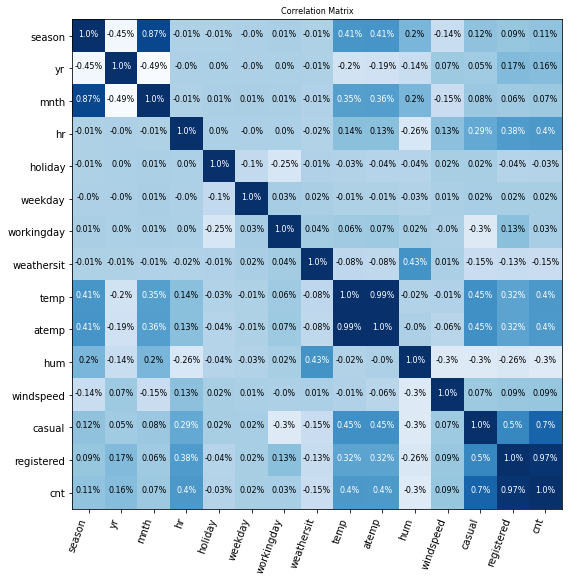

In [1554]:
make_correlation(train_df)

<div id='idconc'/>

[Regresar a Feature engineering](#idfeat)

**Conclusiones**:
- Correlación con `cnt`

>`casual`(0.7) y `registered`(0.9) / Cabe resaltar que casual + registered componen la variable cnt, dado que el objetivo a predecir es cnt, se podría trata de 2 maneras:

     - Eliminar cnt, y realizar 2 regresiones (casual y registeres) y luego sumar ambos resultados para obtener la predicción
     
     - Eliminar casual y registered para tener una única variable a predecir

- Correlación entre `season` y `mnth` (0.87)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos


- Correlación entre `temp` y `atemp` (0.99)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos

     - Dato a tener en cuenta : En la formula de sensación térmica por frio o calor, atemp recibe como variable independiente a la temperatura
     
- Correlación casi nula con `cnt`

> Se considera un rango entre -0.1 a 0.1

      - `mnth`(0.07), `workingday`(0.03), `weekday`(0.02), `holiday` (-0.03), `windspeed` (0.09)   


In [1569]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11999.0,2.210684,1.088798,1.00,1.0000,2.0000,3.0000,4.0000
yr,11999.0,0.279523,0.448784,0.00,0.0000,0.0000,1.0000,1.0000
mnth,11999.0,5.530294,3.433005,1.00,3.0000,5.0000,8.0000,12.0000
hr,11999.0,11.556630,6.911891,0.00,6.0000,12.0000,18.0000,23.0000
holiday,11999.0,0.027752,0.164269,0.00,0.0000,0.0000,0.0000,1.0000
weekday,11999.0,3.009334,2.005264,0.00,1.0000,3.0000,5.0000,6.0000
workingday,11999.0,0.684057,0.464910,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,11999.0,1.435036,0.650894,1.00,1.0000,1.0000,2.0000,4.0000
temp,11999.0,0.465704,0.188576,0.02,0.3200,0.4600,0.6200,0.9600
atemp,11999.0,0.448888,0.169633,0.00,0.3030,0.4545,0.5909,1.0000


### Distribuciones
<div id='id3.3'/>

#### Variable **objetivo**
> Por lo analizado, se encuentra un sesgo positivo, así que existe outliers, el cual veremos que tipo de tratamiento podemos darle, de tal manera no influyan mucho en las predicciones

In [1570]:
target = train_df['cnt']

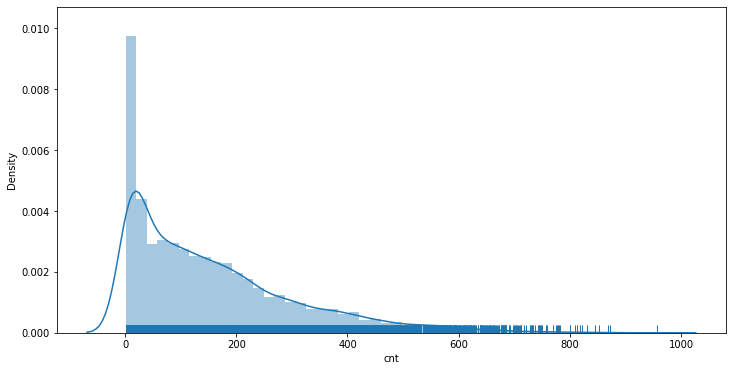

In [1571]:
plt.figure(figsize=(12,6))
sns.distplot(train_df['cnt'], rug = True)
plt.show(); 

#### Transformación Log-Scale
A menudo se prefiere cuando la variable de respuesta sigue una distribución exponencial o está sesgada a la derecha.

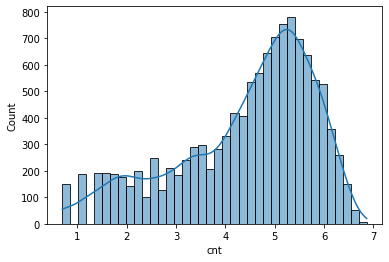

In [1572]:
target_log = np.log1p(target)
sns.histplot(target_log, kde=True)
plt.show()

***Análisis de cuartiles***: Aplicaremos la ley de tukey.

outlier:
- q > Q1 - 1.5*IQR
- q < Q3 + 1.5*IQR

<AxesSubplot:ylabel='cnt'>

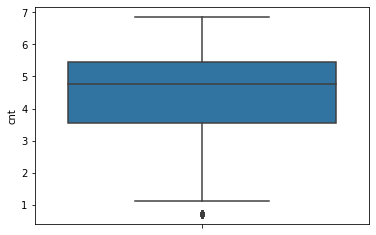

In [1573]:
sns.boxplot(y = target_log)

In [1574]:
cuartiles = pd.qcut(target_log, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuartiles[1]
Q2 = cuartiles[2]
Q3 = cuartiles[3]
IQR = Q3 - Q1

In [1575]:
outl_q = target_log.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

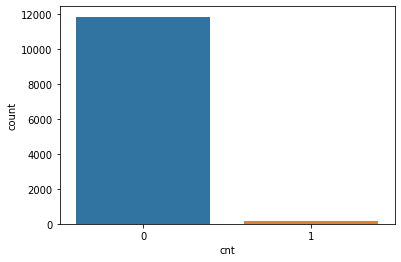

In [1576]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_q)

In [1577]:
outl_q.value_counts()

0    11850
1      149
Name: cnt, dtype: int64

***Análisis de las 3 sigmas***: 
- mínimo = Promedio – 3 * Desviación Estándar
- máximo = Promedio + 3 * Desviación Estándar


In [1578]:
std = np.std(target_log)
mean = np.mean(target_log)

In [1579]:
outl_s = target_log.apply(lambda e: 1 if (e > mean + 3*std)|(e < mean - 3*std) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

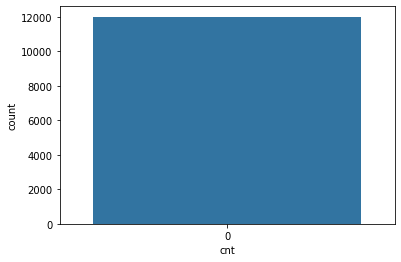

In [1580]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_s)

In [1581]:
outl_s.value_counts()

0    11999
Name: cnt, dtype: int64

***Usaremos los resultados del análisis de tukey aplicado a la transformación log-scale***, procedemos a crear la columna que que distingue los outlier encontrados el cual usaremos para un posterior análisis si se incluye o no en el entrenamiento del modelo

In [1582]:
train_df['outlier'] = outl_q

In [1583]:
train_df['outlier'].value_counts()

0    11850
1      149
Name: outlier, dtype: int64

#### Variables **predictoras**

> ***Visualización de features categóricos***

Asignacion del tipo de dato:

- season, workingday, weathersit, holiday, yr, mnth, hr, weekday: `Categóricos`

                         Visualización de features categóricos (train):                         


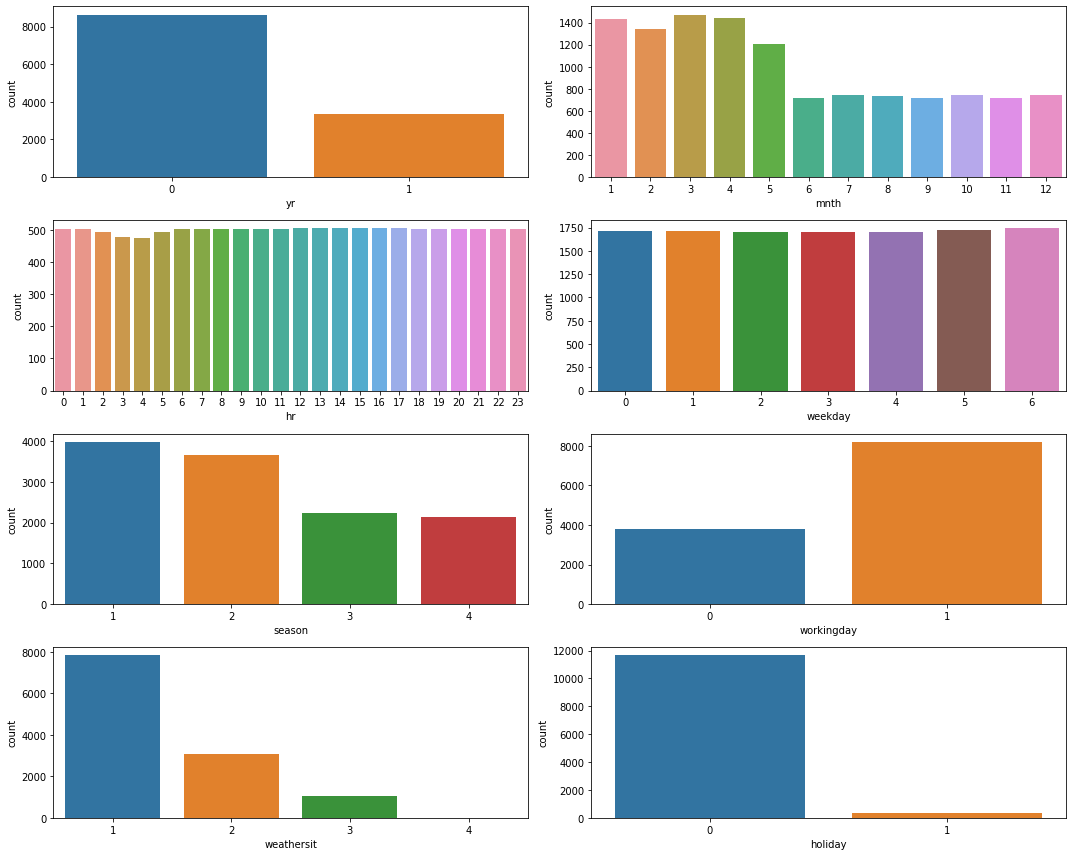

In [1561]:
print('\033[1mVisualización de features categóricos (train):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(train_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(train_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:**  Para el entrenamiento con la columna_valor(weathersit_4) se cuenta con solo 3 valores, así que se procederá a eliminar registros que contengan este valor, y además se logrará visualizar que en el conjunto de prueba este valor no existe

In [1584]:
train_df.weathersit.value_counts()

1    7843
2    3095
3    1058
4       3
Name: weathersit, dtype: int64

                         Visualización de features categóricos (test):                          


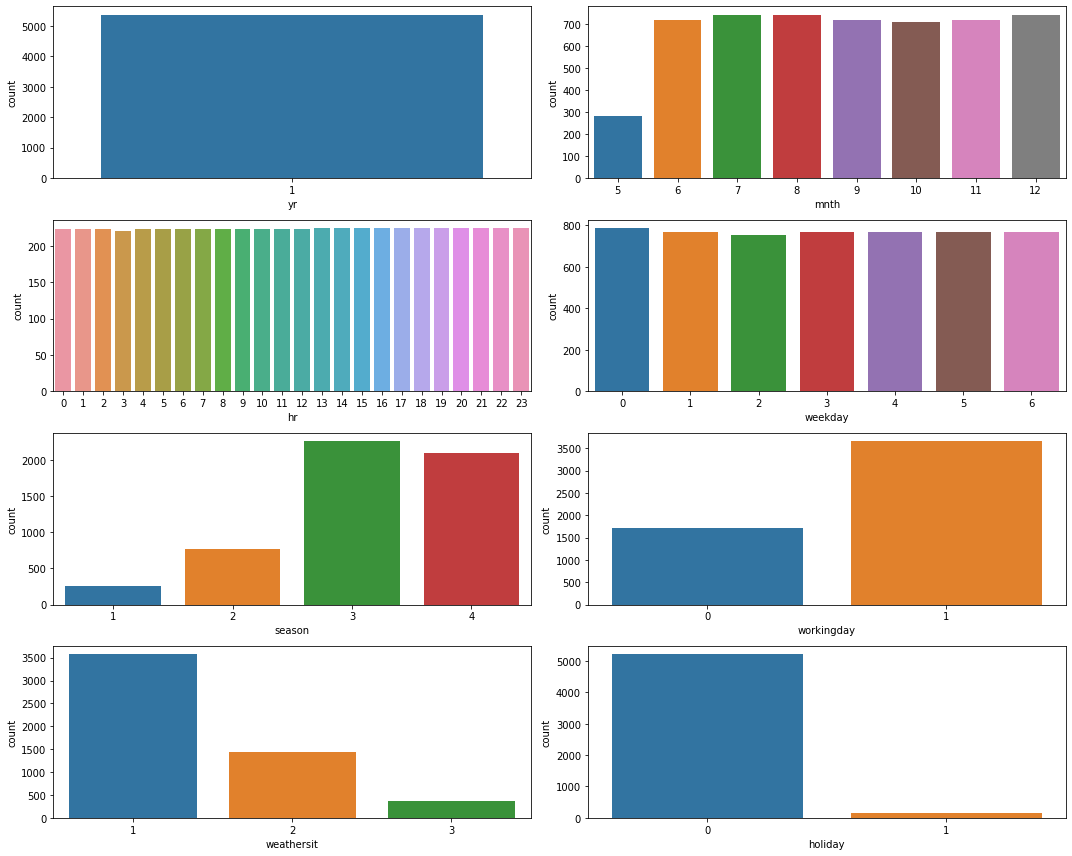

In [1587]:
print('\033[1mVisualización de features categóricos (test):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(test_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(test_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:** En el conjunto de prueba, se cuenta con los siguientes datos:
- mnth: 5-12
- wethersit: 1-3

Resaltándose la falta de valores de mes del 1 al 4 y de wethersit 4

***Visualización de features numéricos***

                                          Distribución de features numéricos (train)                                          


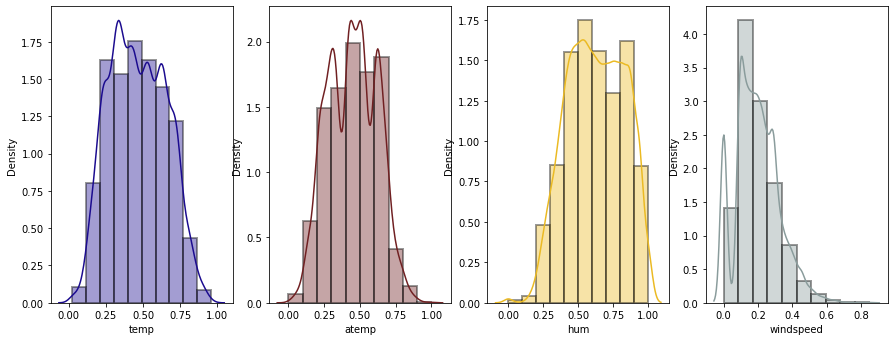

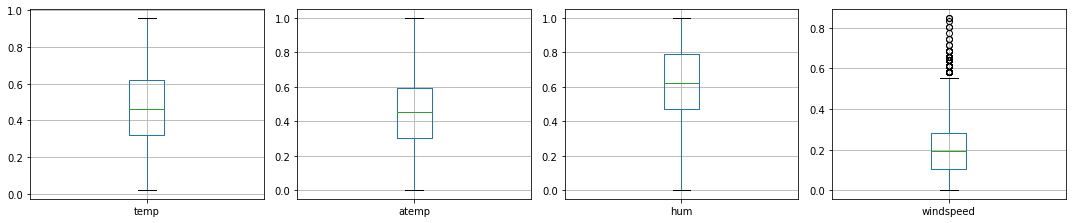

In [1588]:
print('\033[1mDistribución de features numéricos (train)'.center(130))

n = 4
nf = ['temp', 'atemp', 'hum', 'windspeed']
clr = ['r', 'g', 'b', 'g', 'b', 'r']

plt.figure(figsize = [15, 6*math.ceil(len(cf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    sns.distplot(train_df[nf[i]], hist_kws = dict(edgecolor = 'black', linewidth = 2), 
               bins = 10, color = list(np.random.randint([255,255,255])/255))

plt.figure(figsize = [15, 6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    train_df.boxplot(nf[i])

plt.tight_layout()
plt.show()

**Conclusiones:** 
- El feature `windspeed` cuenta con outliers, procederemos a realizar el análisis correspondiente

In [1624]:
train_df.windspeed.count()

11999

In [1629]:
cuart = pd.qcut(train_df.windspeed, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuart[1]
Q2 = cuart[2]
Q3 = cuart[3]
IQR = Q3 - Q1
wind_q = train_df.windspeed.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

In [1632]:
len(wind_q[wind_q == 1]) # 86 registros como outliers, procederemos a eliminar esos registros

86

In [1633]:
train_df['outlier_wind'] = wind_q

In [1636]:
train_df = train_df[train_df['outlier_wind'] == 0]

In [1639]:
train_df = train_df[train_df['outlier'] == 0]

In [1641]:
train_df.shape

(11766, 17)

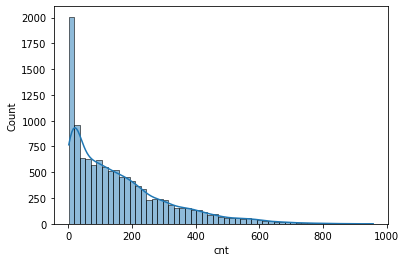

In [1652]:
sns.histplot(train_df.cnt, kde=True)
plt.show()

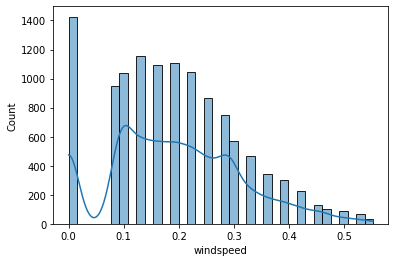

In [1653]:
sns.histplot(train_df.windspeed, kde=True)
plt.show()

- Los features `temp`, `atemp`, `hum`, `windspeed` parecen seguir una distribución normal, lo corroboramos mediante un intervalo de -1 a 1, mediante ciertos estadísticos.

Los estadísticos de asimetría (Skewness) y curtosis pueden emplearse para detectar desviaciones de la normalidad. Un valor de curtosis y/o coeficiente de asimetría entre -1 y 1, es generalmente considerada una ligera desviación de la normalidad. Entre -2 y 2 hay una evidente desviación de la normal pero no extrema.

In [1642]:
print('Kursotis:', stats.kurtosis(train_df['atemp']))
print('Skewness:', stats.skew(train_df['atemp']))

Kursotis: -0.7605809930212595
Skewness: 0.025674344916324972


In [1643]:
print('Kursotis:', stats.kurtosis(train_df['temp']))
print('Skewness:', stats.skew(train_df['temp']))

Kursotis: -0.8497271154180095
Skewness: 0.11298915344992352


In [1644]:
print('Kursotis:', stats.kurtosis(train_df['hum']))
print('Skewness:', stats.skew(train_df['hum']))

Kursotis: -0.8488387202600838
Skewness: -0.09306347155555174


In [1645]:
print('Kursotis:', stats.kurtosis(train_df['windspeed']))
print('Skewness:', stats.skew(train_df['windspeed']))

Kursotis: -0.1870066034447473
Skewness: 0.3480784979173213


## 4. Feature engineering
<div id='id4'/>

<div id='idfeat'/>

Análisis previo de la matrix de correlación -> [link](#idconc)

### Selección de features con linear regression

In [1654]:
train_prep_1 = train_df.drop(['casual','registered', 'outlier', 'outlier_wind'], axis = 1).copy()

In [1655]:
train_prep_1.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [1657]:
X_reg = train_prep_1.drop(['cnt'], axis = 1)
y_reg = train_prep_1['cnt']

In [1658]:
import statsmodels.api as sm
X_constant = sm.add_constant(X_reg)
lin_reg = sm.OLS(y_reg, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     577.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:58:43   Log-Likelihood:                -73043.
No. Observations:               11766   AIC:                         1.461e+05
Df Residuals:                   11753   BIC:                         1.462e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.4272      7.236     -3.376      0.001     -38.611     -10.244
season        12.9034      2.090      6.172      0.000       8.806      17.001
yr            87.3714      2.869     30.450      0.000      81.747      92.996
mnth           1.6835      0.665      2.532      0.011       0.380       2.987
hr             6.4691      0.169     38.300      0.000       6.138       6.800
holiday      -22.2647      7.005     -3.179      0.001     -35.995      -8.534
weekday        1.6249      0.557      2.918      0.004       0.533       2.717
workingday    -0.5539      2.469     -0.224      0.822      -5.393       4.286
weathersit    -6.1496      1.943     -3.165      0.002      -9.958      -2.341
temp          37.5108     49.682      0.755      0.450     -59.875     134.897
atemp        270.9382     55.328      4.897      0.000     162.486     379.391
hum         -149.9532      6.872    -21.821      0.000    -163.423    -136.483
windspeed     32.5870     10.323      3.157      0.002      12.352      52.822
==============================================================================
Omnibus:                     2198.122   Durbin-Watson:                   0.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4117.313
Skew:                           1.161   Prob(JB):                         0.00
Kurtosis:                       4.735   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Conclusiones:**
- Las variables no significativas (>0.05) encontradas en el modelo son:
  * `workingday`
  * `temp`

### Selección de features con Recursive Feature Elimination

In [1659]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
model = XGBRegressor()

selector = RFECV(model, step=3, min_features_to_select = 3, cv = 4)
selector.fit(X_reg, y_reg)

RFECV(cv=4,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, reg_alpha=None,
                             reg_lambda=None, 

In [1660]:
print(X_reg.columns)
print(selector.ranking_)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[1 1 2 1 1 1 1 1 1 1 2 2]


In [1661]:
selector.grid_scores_.mean() # Promedio de R^2 para CV en 4

0.6340021728946238

**Conclusiones:**
- Las variables mas importantes son:
  * `season`
  * `yr`
  * `hr`
  * `workingday`
  * `weathersit`
  * `temp`
  
- Las variables menos importantes son:
  * `mnth`
  * `hum`
  * `windspeed`
  

## 5. Preprocesamiento de datos
<div id='id5'/>

In [1668]:
train_df_prep_1 = train_df.drop(['outlier', 'outlier_wind', 'casual', 'registered'], axis = 1)
train_df_prep_1 = train_df_prep_1[ train_df_prep_1['weathersit'] <= 3]
train_df_prep_1

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
6,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,239
11995,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,170
11996,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,130
11997,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,98


### 5.1. Usando el 1er método de selección + correlación lineal

<div id='idtrainfs1'/>

[Prep Prueba](#idpruebafs1)

Eliminamos `temp`,`workingday` y `mnth`

In [1802]:
train_prep_fs_1 = train_df_prep_1.drop(['temp','workingday','mnth'],axis = 1)

In [1803]:
train_prep_fs_1.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'atemp',
       'hum', 'windspeed', 'cnt'],
      dtype='object')

#### Variables dummies
Variables categoricas nominales: [season, weathersit, 'holiday', 'weekday', yr, hr]

No es necesario `holiday`,`yr` ya que se encuentran en valores 0 y 1

In [1751]:
train_prep_fs_1_2 = train_prep_fs_1.copy()
# train_prep_fs_1_2 = pd.get_dummies(train_prep_fs_1, columns=['season', 'hr', 'weathersit', 'weekday'])
train_prep_fs_1_2.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [1530]:
train_df_prep_2['cnt'] = np.log1p(train_df_prep_2['cnt'])

##### Escalado de las variables
Manejaremos un escalado StandardScaler para la variable objetivo

In [1752]:
train_prep_fs_1_3 = train_prep_fs_1_2.copy()

In [1679]:
# st_output = MinMaxScaler()
# train_prep_fs_1_3.loc[:,['cnt']] = st_output.fit_transform(train_prep_fs_1_3.loc[:,['cnt']])

In [1753]:
train_prep_fs_1_3.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11763.0,2.225028,1.088084,1.0,1.0000,2.0000,3.0000,4.0000
yr,11763.0,0.278670,0.448364,0.0,0.0000,0.0000,1.0000,1.0000
hr,11763.0,11.634107,6.903735,0.0,6.0000,12.0000,18.0000,23.0000
holiday,11763.0,0.027969,0.164891,0.0,0.0000,0.0000,0.0000,1.0000
weekday,11763.0,3.009181,2.005455,0.0,1.0000,3.0000,5.0000,6.0000
weathersit,11763.0,1.431778,0.646495,1.0,1.0000,1.0000,2.0000,3.0000
atemp,11763.0,0.451582,0.168838,0.0,0.3182,0.4545,0.5909,1.0000
hum,11763.0,0.626227,0.200008,0.0,0.4700,0.6200,0.7900,1.0000
windspeed,11763.0,0.193259,0.120032,0.0,0.1045,0.1940,0.2836,0.5522
cnt,11763.0,160.670492,151.561271,2.0,36.0000,121.0000,234.0000,957.0000


#### Otra manera

#### División del conjuntos de datos, en train y validation

In [1804]:
train_prep_fs_1.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [1806]:
# (nro. filas, nro. columnas)
train_prep_fs_1.shape

(11763, 10)

Se probará 85%(train) y 15%(test)

In [1960]:
X_1 = train_prep_fs_1.drop(['cnt'], axis = 1)
y_1 = train_prep_fs_1['cnt']

In [1961]:
train_X_1, val_X_1, train_y_1, val_y_1 = train_test_split(X_1, y_1, test_size=0.15, random_state = 2208)

### 5.2. Usando el 2do método de selección + correlación lineal

<div id='idtrainfs2'/>

[Prep Prueba](#idpruebafs2)

Eliminamos `windspeed`, `season`, `hum`, `temp`

In [1802]:
train_prep_fs_2 = train_df_prep_1.drop(['windspeed','temp','season','hum'],axis = 1)

In [1803]:
train_prep_fs_2.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'atemp',
       'hum', 'windspeed', 'cnt'],
      dtype='object')

In [1751]:
train_prep_fs_1_2 = train_prep_fs_1.copy()
# train_prep_fs_1_2 = pd.get_dummies(train_prep_fs_1, columns=['season', 'hr', 'weathersit', 'weekday'])
train_prep_fs_1_2.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [1530]:
train_df_prep_2['cnt'] = np.log1p(train_df_prep_2['cnt'])

##### Escalado de las variables
Manejaremos un escalado StandardScaler para la variable objetivo

In [1752]:
train_prep_fs_1_3 = train_prep_fs_1_2.copy()

In [1679]:
# st_output = MinMaxScaler()
# train_prep_fs_1_3.loc[:,['cnt']] = st_output.fit_transform(train_prep_fs_1_3.loc[:,['cnt']])

In [1753]:
train_prep_fs_1_3.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11763.0,2.225028,1.088084,1.0,1.0000,2.0000,3.0000,4.0000
yr,11763.0,0.278670,0.448364,0.0,0.0000,0.0000,1.0000,1.0000
hr,11763.0,11.634107,6.903735,0.0,6.0000,12.0000,18.0000,23.0000
holiday,11763.0,0.027969,0.164891,0.0,0.0000,0.0000,0.0000,1.0000
weekday,11763.0,3.009181,2.005455,0.0,1.0000,3.0000,5.0000,6.0000
weathersit,11763.0,1.431778,0.646495,1.0,1.0000,1.0000,2.0000,3.0000
atemp,11763.0,0.451582,0.168838,0.0,0.3182,0.4545,0.5909,1.0000
hum,11763.0,0.626227,0.200008,0.0,0.4700,0.6200,0.7900,1.0000
windspeed,11763.0,0.193259,0.120032,0.0,0.1045,0.1940,0.2836,0.5522
cnt,11763.0,160.670492,151.561271,2.0,36.0000,121.0000,234.0000,957.0000


#### División del conjuntos de datos, en train y validation

In [1804]:
train_prep_fs_2.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [1806]:
# (nro. filas, nro. columnas)
train_prep_fs_2.shape

(11763, 10)

Se probará 80% (train) y 20% (validación)

In [1807]:
X_2 = train_prep_fs_2.drop(['cnt'], axis = 1)
y_2 = train_prep_fs_2['cnt']

In [1808]:
train_X_2, val_X_2, train_y_2, val_y_2 = train_test_split(X_2, y_2, test_size=0.15, random_state = 2208)

## 6. Modelos de entrenamiento
<div id='id6'/>
Se probará Modelos de Bosques aleatorios, XGboost y Redes neuronales

### Random Forest
<div id='id6.1'/>

#### 1ro

In [1999]:
my_param_grid = {'n_estimators':[100, 250, 500], 'max_features':['sqrt', 'log2'], 'max_depth':[10, 20]}

In [2000]:
rf_1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
rf_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   1.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   1.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   1.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   1.8s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   4.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   8.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   6.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   3.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   4.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   5.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=  16.7s
[CV] END ..max_depth=10, max_features=sqrt, n_es

In [1965]:
rf_1.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=250)

In [1966]:
# Este es
rf_1.best_score_*(-1)

53.61479702000902

In [1967]:
# Este es
y_hat_1 = grid.predict(val_X_1)
y_hat_1

array([  9.28001781, 117.26909524,  14.462     , ..., 319.14203361,
        20.05829717, 331.17064444])

In [1986]:
rf_1 = RandomForestRegressor(max_depth= 20, max_features = 'sqrt', n_estimators= 500)
rf_1.fit(train_X_1, train_y_1)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500)

In [1992]:
rf_pred_1 = rf_1.predict(val_X_1)
rf_pred_1

array([  8.87814824, 119.58717878,  15.17760303, ..., 324.14156353,
        22.67924554, 334.17296899])

Visualizando la métrica a minimizar

---

In [1993]:
predicns = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [1994]:
predicns['predict_val'] = rf_pred_1.reshape(-1,1)

In [1995]:
predicns

,true_val,predict_val
0,3,8.878148
1,119,119.587179
2,10,15.177603
3,104,114.467270
4,10,16.605529
...,...,...
1760,102,157.501684
1761,91,105.413000
1762,285,324.141564
1763,5,22.679246


In [1996]:
rmse = round(np.sqrt(mean_squared_error(predicns['true_val'], predicns['predict_val'])),4)
rmse

49.0112

---

In [1970]:
# Este es
predictions = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [1971]:
predictions['predict_val'] = y_hat_1.reshape(-1,1)

In [1972]:
predictions

,true_val,predict_val
0,3,9.280018
1,119,117.269095
2,10,14.462000
3,104,113.569992
4,10,16.730160
...,...,...
1760,102,166.213745
1761,91,94.120000
1762,285,319.142034
1763,5,20.058297


In [1973]:
rmse = round(np.sqrt(mean_squared_error(predictions['true_val'], predictions['predict_val'])),4)
rmse

48.5002

### XGBoost
<div id='id6.2'/>

In [1845]:
from sklearn import metrics

In [1846]:
def rmse(y_true, y_prediction):
    return np.sqrt(mean_squared_error(y_true, y_prediction))
rmse_scorer = metrics.make_scorer(rmse, greater_is_better = False)

In [1881]:
# model
model = xgb.XGBRegressor()
parameters = {'n_estimators': [100, 150], 'max_depth': [10,20], 'learning_rate': [0.08, 0.1, 0.15]}
gridsearch_model = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2)
gridsearch_model.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   4.8s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   3.1s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   2.1s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   2.7s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   3.4s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   4.3s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   3.4s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   7.7s
[CV] END .learning_rate=0.08, max_depth=20, n_estimators=100; total time=  24.9s
[CV] END .learning_rate=0.08, max_depth=20, n_es

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [1884]:
print('Mejor modelo: ', gridsearch_model.best_params_)

Mejor modelo:  {'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 150}


In [1885]:
grid.best_score_*(-1)

75.23611100249416

In [ ]:
xg_1 = xgb.XGBRegressor(n_estimators = , max_depth = , learning_rate =)
xg_1.fit(X, y)

### Red neuronal
<div id='id6.3'/>

In [1174]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomUniform
import os
from tensorflow.keras.models import Model, load_model

In [1175]:
# Creamos una función para implementar una devolución de llamada de ModelCheckpoint con un nombre de archivo específico
def create_model_checkpoint(model_name, save_path="model_experiments_2"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, 
                                            save_best_only=True) 

In [1800]:
def model_MLANN(train, train_label, test, test_label, name):
    
    model = tf.keras.Sequential([
        layers.Dense(12, activation = 'tanh', input_shape = (9,)),
        layers.Dense(1),
    ], name = name)
    
    model.compile(loss = 'mse',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.08),
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(train, train_label, epochs = 150,callbacks = [create_model_checkpoint(model_name=model.name)], validation_data =(test,test_label), verbose = 2)
    
    return model, history

In [1801]:
rn_model, history = model_MLANN(train_X, train_y, val_X, val_y, 'rn_model')

Epoch 1/150
276/276 - 1s - loss: 26681.9141 - root_mean_squared_error: 163.3460 - val_loss: 17938.7930 - val_root_mean_squared_error: 133.9358
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
Epoch 2/150
276/276 - 1s - loss: 16563.5215 - root_mean_squared_error: 128.6993 - val_loss: 17330.9668 - val_root_mean_squared_error: 131.6471
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
Epoch 3/150
276/276 - 0s - loss: 16415.2852 - root_mean_squared_error: 128.1221 - val_loss: 16254.8340 - val_root_mean_squared_error: 127.4944
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
Epoch 4/150
276/276 - 1s - loss: 15516.5703 - root_mean_squared_error: 124.5655 - val_loss: 15323.7725 - val_root_mean_squared_error: 123.7892
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
Epoch 5/150
276/276 - 0s - loss: 14417.2812 - root_mean_squared_error: 120.0720 - val_loss: 13956.0557 - val_root_mean_squared_error: 118.1357
I

KeyboardInterrupt: 

In [1407]:
rn_model.evaluate(val_X, val_y)

40/40 [==============================] - 0s 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460


[0.0021196205634623766, 0.046039335429668427]

In [1408]:
rn_best_model = tf.keras.models.load_model(f"model_experiments_2/rn_model")

In [1409]:
rn_best_model.evaluate(val_X, val_y)

40/40 [==============================] - 0s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440


[0.0019387061474844813, 0.04403074085712433]

In [1410]:
history_rn = pd.DataFrame(history.history)
history_rn

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.049993,0.223590,0.023012,0.151698
1,0.015006,0.122499,0.010371,0.101837
2,0.009947,0.099735,0.009026,0.095003
3,0.009310,0.096488,0.008763,0.093608
4,0.008885,0.094260,0.008317,0.091199
...,...,...,...,...
145,0.002205,0.046961,0.002285,0.047807
146,0.002187,0.046770,0.002410,0.049092
147,0.002217,0.047086,0.002342,0.048391
148,0.002227,0.047196,0.002316,0.048127


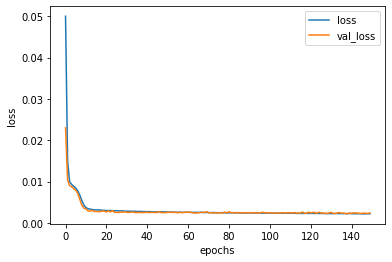

In [1411]:
plt.plot(history_rn.index, history_rn['loss'])
plt.plot(history_rn.index, history_rn['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show();

In [1417]:
test_rn = rn_best_model.predict(test_df_prep_1)

In [1418]:
test_rn_norm = st_output.inverse_transform(test_rn)

In [1419]:
test2 = np.round(np.expm1(test_rn_norm))
test2

array([[12.],
       [10.],
       [20.],
       ...,
       [80.],
       [61.],
       [42.]], dtype=float32)

In [1420]:
prueba2 = pd.DataFrame(test2, columns = ['pred'])

In [1421]:
prueba2

,pred
0,12.0
1,10.0
2,20.0
3,51.0
4,127.0
...,...
5375,147.0
5376,116.0
5377,80.0
5378,61.0


In [1423]:
prueba2.to_csv('Sandtw.csv', header=True, index=False)

<AxesSubplot:ylabel='Density'>

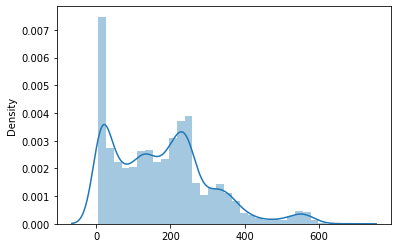

In [1173]:
sns.distplot(test)

<AxesSubplot:ylabel='Density'>

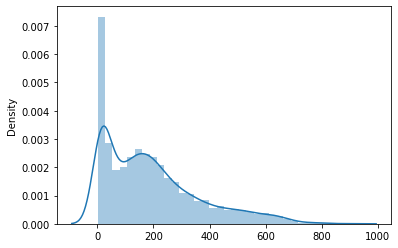

In [1422]:
sns.distplot(test2)

## 7. Pruebas
<div id='id7'/>

In [1913]:
test_prep_1 = test_df.drop(['instant', 'dteday'], axis = 1)

In [1914]:
test_prep_1.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


### Preprocesamiento test [Método de selección 1](#idtrainfs1)
<div id='idpruebafs1'/>

In [1915]:
test_prep_fs_1 = test_prep_1.drop(['temp','workingday','mnth'],axis = 1)

In [1916]:
test_prep_fs_1.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed
0,2,1,4,0,0,1,0.5000,0.68,0.0896
1,2,1,5,0,0,1,0.4848,0.72,0.1045
2,2,1,6,0,0,1,0.4848,0.63,0.1343
3,2,1,7,0,0,1,0.5000,0.68,0.1940
4,2,1,8,0,0,1,0.5303,0.56,0.1642


In [1918]:
test_rf_1 = grid.predict(test_prep_fs_1_2)

In [1917]:
test_rf_1 = rf.predict(test_prep_fs_1_2)

In [1919]:
test_rf_1 = np.round(test_rf_1.reshape(-1,1))
test_rf_1

array([[ 23.],
       [ 21.],
       [ 29.],
       ...,
       [100.],
       [101.],
       [ 56.]])

In [1920]:
prueba_rf_1 = pd.DataFrame(test_rf_1, columns = ['pred'])

In [1921]:
prueba_rf_1

,pred
0,23.0
1,21.0
2,29.0
3,154.0
4,255.0
...,...
5375,188.0
5376,141.0
5377,100.0
5378,101.0


In [1922]:
prueba_rf_1.to_csv('Day 3/Sandtw.csv', header=True, index=False)

### Preprocesamiento test [Método de selección 2](#idtrainfs2)
<div id='idpruebafs2'/>

In [ ]:
test_prep_fs_2 = test_prep_1.drop(['windspeed','temp','season','hum'],axis = 1)

In [ ]:
test_prep_fs_2.head()